In [1]:
import os
os.chdir("..")
os.getcwd()

'c:\\Users\\ADEGOKE\\Desktop\\Hybrid-Video-Recommender-System'

## Load the 1M Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline 
warnings.filterwarnings("ignore")

df_ratings = pd.read_csv("data/raw/ratings.dat", sep="::", engine="python",
                      names=["user_id", "movie_id", "rating", "timestamp"])

df_movies = pd.read_csv("data/raw/movies.dat", sep="::", engine="python",
                     names=["movie_id", "title", "genres"], encoding="latin-1")


In [3]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
df_movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### Check for missing values

In [5]:
df_ratings.isnull().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [6]:
df_ratings.shape

(1000209, 4)

In [7]:
df_movies.isnull().sum()

movie_id    0
title       0
genres      0
dtype: int64

In [8]:
df_movies.shape

(3883, 3)

### Check for unique values

In [9]:
df_ratings["user_id"].nunique(), df_ratings["movie_id"].nunique()

(6040, 3706)

In [10]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [11]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [12]:
df_ratings["rating"].value_counts(normalize=True)

rating
4    0.348898
3    0.261142
5    0.226263
2    0.107535
1    0.056162
Name: proportion, dtype: float64

In [13]:
n_users = df_ratings.user_id.nunique()
n_items = df_ratings.movie_id.nunique()
density = len(df_ratings) / (n_users * n_items)

if density < 0.01:
    msg = "Excellent sparsity for ALS"
elif density < 0.05:
    msg = "Good sparsity for ALS MovieLens 1M range"
elif density < 0.10:
    msg = "Moderate sparsity - consider memory optimization"
else:
    msg = "High density - consider alternative algorithms"

print(msg)
density

Good sparsity for ALS MovieLens 1M range


0.044683625622312845

### EDA

In [19]:
# Calculate User Activity
user_counts = df_ratings.groupby("user_id").size()
print("User Activity Summary:")
print(f"Total Users: {len(user_counts):.1f}")
print(f"Mean Interaction per User: {user_counts.mean():.1f}")
print(f"Median Interaction per User: {user_counts.median():.1f}")
print(f"Standard Deviation of Interactions: {user_counts.std():.1f}")
print(f"Minimun Interactions: {user_counts.min():.1f}")
print(f"Maximun Interactions: {user_counts.max():.1f}")

# For ALS decisions
print(f"\nALS Considerations:")
print(f"User with < 5 interactions: {(user_counts < 5).sum()} ({(user_counts < 5).sum()/len(user_counts)*100:.1f}%)")
print(f"User with < 10 interactions: {(user_counts < 10).sum()} ({(user_counts < 10).sum()/len(user_counts)*100:.1f}%)")

User Activity Summary:
Total Users: 6040.0
Mean Interaction per User: 165.6
Median Interaction per User: 96.0
Standard Deviation of Interactions: 192.7
Minimun Interactions: 20.0
Maximun Interactions: 2314.0

ALS Considerations:
User with < 5 interactions: 0 (0.0%)
User with < 10 interactions: 0 (0.0%)


Text(0.5, 1.0, 'Complementary CDF')

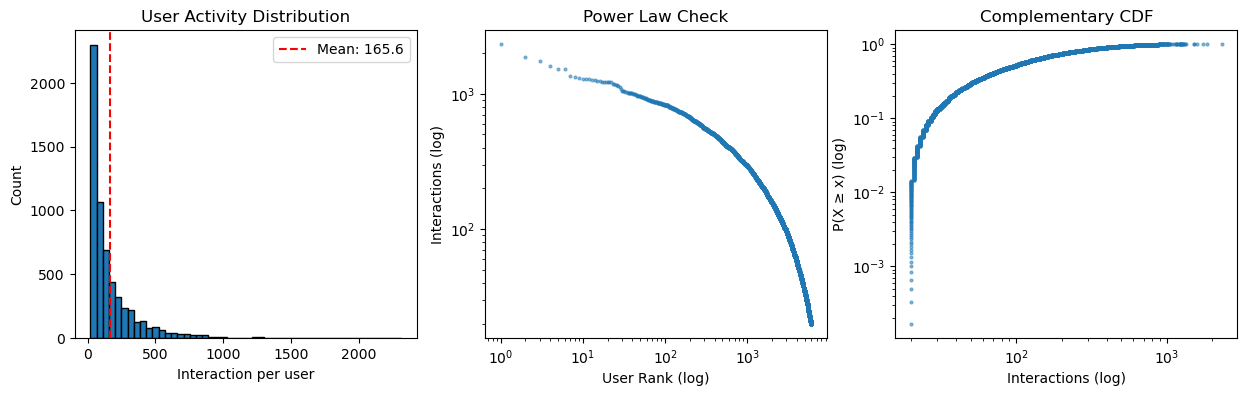

In [29]:
sorted_counts = user_counts.sort_values(ascending=False).reset_index(drop=True)

# Plot 1: Histogram
fig, axes = plt.subplots(1, 3, figsize = (15, 4))
axes[0].hist(user_counts, bins = 50, edgecolor = "black")
axes[0].set_xlabel("Interaction per user")
axes[0].set_ylabel("Count")
axes[0].set_title("User Activity Distribution")
axes[0].axvline(user_counts.mean(), color = "red", linestyle = "--", label = f"Mean: {user_counts.mean():.1f}")
axes[0].legend()

# Plot 2: Log-log plot for power law check
axes[1].loglog(sorted_counts.index + 1, sorted_counts.values, "o", alpha=0.5, markersize=2)
axes[1].set_xlabel("User Rank (log)")
axes[1].set_ylabel("Interactions (log)")
axes[1].set_title("Power Law Check")

# Plot 3: Complementary CDF
ccdf = 1 - np.arange(len(sorted_counts)) / len(sorted_counts)
axes[2].loglog(sorted_counts.values, ccdf, "o", alpha=0.5, markersize=2)
axes[2].set_xlabel("Interactions (log)")
axes[2].set_ylabel("P(X ≥ x) (log)")
axes[2].set_title("Complementary CDF")

Text(0.5, 1.0, 'Power Law Check')